# enrichment function

This notebook shows how to use the enrichment function.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import greatpy as great
import pandas as pd
from math import inf
from numpy import log,nan, int64,cov,corrcoef
from scipy.stats import pearsonr
from seaborn import scatterplot as sp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## I Compute the p-values

In [3]:
test = "../data/tests/test_data/input/03_srf_hg19.bed"
regdom = "../data/human/hg19/regulatory_domain.bed"
great_out = "../data/tests/test_data/output/03_srf_hg19_output_great_webserver.tsv"
size = "../data/human/hg19/chr_size.bed"

In [4]:
enrichment = great.tl.GREAT.enrichment(
    test_file=test,
    regdom_file=regdom,
    chr_size_file=size,
    annotation_file="../data/human/ontologies.csv",
    binom=True,
    hypergeom=True,
    )
great.tl.GREAT.set_fdr(enrichment)
great.tl.GREAT.set_bonferroni(enrichment)
enrichment

## II Compare p values between binomial and hypergeometric tests 

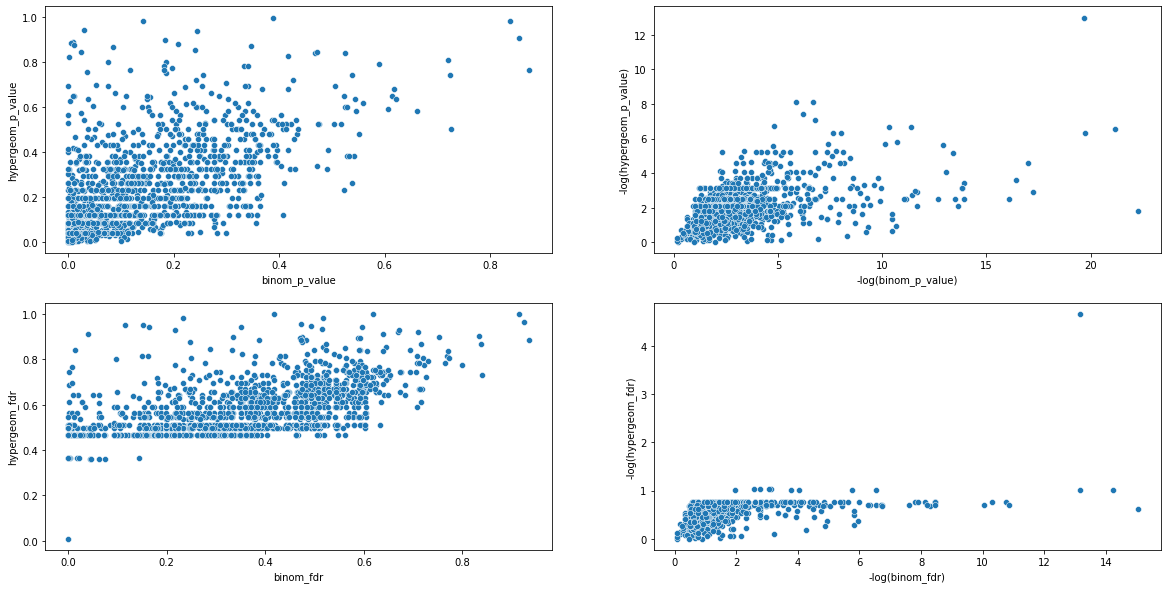

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(20,10))
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=False,ax=ax[0,0])
great.pl.scatterplot(
    enrichment,
    "binom_p_value",
    "hypergeom_p_value",
    minus_log10=True,ax=ax[0,1])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=False,ax=ax[1,0])
great.pl.scatterplot(
    enrichment,
    "binom_fdr",
    "hypergeom_fdr",
    minus_log10=True,ax=ax[1,1])
plt.show()

In [ ]:
pd.DataFrame({
        "binom_vs_hyper": [cov(m = list(enrichment["binom_p_value"]), y = list(enrichment["hypergeom_p_value"]))[0][1],pearsonr(list(enrichment["binom_p_value"]), list(enrichment["hypergeom_p_value"]))[0]],
        "binom_fdr_vs_hyper_fdr":[cov(m = list(enrichment["binom_fdr"]), y = list(enrichment["hypergeom_fdr"]))[0][1],pearsonr(list(enrichment["binom_fdr"]), list(enrichment["hypergeom_fdr"]))[0]]},
        index=["cov","pearson"])

,binom_vs_hyper,binom_fdr_vs_hyper_fdr
binom_vs_hyper,1.44656e-02,1.06792e-02
pearson,5.73125e-01,5.44640e-01
